# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
#env.close()
# Commenting this in order to use this later

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [7]:
import torch
import pandas as pd
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

### 5. Training the Agent


__Training Algorithm__

The environment has a large state space with 37 dimensions and a discrete action space with just 4 actions. As a result, this problem is well suited to solve using [Deep-Q Network (DQN)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

The agent will be trained using the DQN methodology along with couple of enhancements:
- [Double DQN](https://arxiv.org/abs/1509.06461)
- [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)

These methodologies are coded up in dqn_agent.py

__Structure of the Code__

We create the dqn() function below to run the training for a given set of hyperparameters. The hyperparameters are used in the creation of the 'agent' instance which is then passed to the dqn() function to train. The hyperparameters are read from a csv file. This allows us to run training for different combinations of hyperparameters in order to find the optimal hyperparameters. We save the weights for the approximated Q function (the weights of the deep neural network) for each iteration.

In [8]:
# Re-create Environment

#env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# number of states
state = env_info.vector_observations[0]
state_size = len(state)

In [20]:
# load Hyperparameters

hyperp_iter = pd.read_csv('hyperparameters.csv')
hyperp_iter

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err
0,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.5,0.5,0.001
1,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.1,0.5,0.001
2,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.5,0.3,0.001
3,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.7,0.7,0.001
4,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.5,0.5,0.010


In [21]:
# DQN function to run the training

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, checkpoint_filename='checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start
    solved_episode = None
    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        #print('resetting env')
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        #print('episode: {}'.format(i_episode))
        for t in range(max_t):
            #print('max_t: {}'.format(t))
            #print('agent acting')
            action = agent.act(state, eps)
            #print('env step')
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]
            #print('agent step')
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                #print('we are done')
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_filename)
            solved_episode = i_episode-100
            break
    
    
    
    return scores, solved_episode

In [22]:
# import the Agent Class
from dqn_agent import Agent

In [23]:
# Run training for Double DQN and Prioritized Experience Replay

# True to apply Double DQN
ddqn = True

# True to apply Prioritized Experience Replay
exp_replay = True

scores =[]
solved_episodes = []

iter_range = range(len(hyperp_iter))



for i in iter_range:
    hyperp_i = tuple(hyperp_iter.iloc[i,:])  # read each hyperparameters combination as a tuple
    print('\n\nHyperparameters: ')
    print(hyperp_iter.iloc[[i]])
    agent = Agent(state_size=state_size, action_size=action_size, seed=0, hyperp = hyperp_i[1:10], ddqn=ddqn, 
                  hyperp_exp_replay = hyperp_i[10:13], exp_replay=exp_replay)

    checkpoint_iter = i+1
    checkpoint_filename = 'checkpoint_ddqn_er_'+str(checkpoint_iter)+'.pth'
    
    print('Starting training')
    score, solved_episode = dqn(agent, n_episodes=int(hyperp_i[0]), checkpoint_filename=checkpoint_filename)
    
    scores.append(score)
    solved_episodes.append(solved_episode)
    



Hyperparameters: 
      E       N  k  C    M      lr     Y      t  fc1_units  fc2_units    a  \
0  2000  100000  4  4  256  0.0005  0.99  0.001        128         64  0.5   

     b  p_err  
0  0.5  0.001  
Starting training
Episode 100	Average Score: 0.06
Episode 200	Average Score: 2.08
Episode 300	Average Score: 6.84
Episode 400	Average Score: 9.32
Episode 500	Average Score: 11.09
Episode 564	Average Score: 13.03
Environment solved in 464 episodes!	Average Score: 13.03


Hyperparameters: 
      E       N  k  C    M      lr     Y      t  fc1_units  fc2_units    a  \
1  2000  100000  4  4  256  0.0005  0.99  0.001        128         64  0.1   

     b  p_err  
1  0.5  0.001  
Starting training
Episode 100	Average Score: 0.11
Episode 200	Average Score: 1.22
Episode 300	Average Score: 5.70
Episode 400	Average Score: 9.02
Episode 500	Average Score: 11.27
Episode 568	Average Score: 13.01
Environment solved in 468 episodes!	Average Score: 13.01


Hyperparameters: 
      E       N  k  C   

In [24]:
# Process final results

solved_episodes_df = solved_episodes

hyperp_iter['episode'] = solved_episodes_df
hyperp_iter.to_csv('ddqn_er_solved_5.csv', index=False)

hyperp_iter['score'] = scores
hyperp_iter.to_pickle('ddqn_er_solved_5.pkl')

hyperp_iter

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score
0,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.5,0.5,0.001,464,"[2.0, 0.0, 1.0, 0.0, -1.0, 2.0, 1.0, 1.0, 0.0,..."
1,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.1,0.5,0.001,468,"[0.0, 1.0, 0.0, -3.0, 1.0, -1.0, 0.0, 0.0, 1.0..."
2,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.5,0.3,0.001,481,"[-2.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0..."
3,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.7,0.7,0.001,382,"[0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.5,0.5,0.010,585,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, -1.0, -1.0, 0.0..."


### 6. Comparing Hyperparameter Iteration Results

We have run multiple iterations with different hyperparameter values. 
Below we first combine the multiple dataframes saved for DDQN and Prioritized Experience Replay, both True and find the values that gave the minimum value of the "episode" column.

We will then compare this with the "episode" value for DQN and DDQN respectively.

In [9]:
er_dfs = [pd.read_pickle('ddqn_er_solved_'+str(i)+'.pkl') for i in range(1,6)]

er_df = pd.concat(er_dfs)
er_df = er_df.reset_index(drop=True)

er_df

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score
0,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.5,0.5,0.001,426.0,"[1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0,..."
1,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.1,0.5,0.001,395.0,"[0.0, 0.0, 0.0, 2.0, -1.0, 1.0, 1.0, -4.0, -1...."
2,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.5,0.3,0.001,495.0,"[0.0, 0.0, 2.0, 1.0, 1.0, 0.0, -3.0, -1.0, 0.0..."
3,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.7,0.7,0.001,372.0,"[-3.0, -1.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0...."
4,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.5,0.5,0.010,442.0,"[-1.0, -1.0, 0.0, 2.0, 0.0, 0.0, -1.0, 0.0, -1..."
5,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0.5,0.5,0.001,410.0,"[1.0, 0.0, 2.0, -1.0, 0.0, 1.0, 1.0, 2.0, 0.0,..."
6,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0.1,0.5,0.001,416.0,"[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.0..."
7,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0.5,0.3,0.001,488.0,"[0.0, 1.0, 1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0..."
8,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0.7,0.7,0.001,395.0,"[-1.0, -1.0, 0.0, 2.0, 2.0, 0.0, -1.0, 0.0, 0...."
9,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0.5,0.5,0.010,384.0,"[-1.0, -1.0, 1.0, 1.0, 0.0, -1.0, -1.0, 0.0, 0..."


In [10]:
# Group data by the hyperparameter values (except a, b, p_err)
group_cols = ['E', 'N', 'k', 'C', 'M', 'lr', 'Y', 't', 'fc1_units', 'fc2_units']

er_group = er_df.groupby(group_cols)
er_agg = er_group['episode'].aggregate([np.min])
er_agg.reset_index(inplace=True)

er_agg.rename(columns = {'amin': 'episode'}, inplace=True)
er_agg

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,episode
0,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,384.0
1,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,372.0
2,2000,100000,4,4,64,0.0005,0.99,0.010,128,64,433.0
3,2000,100000,4,4,64,0.0005,0.99,0.050,128,64,410.0
4,2000,100000,4,4,64,0.0050,0.99,0.001,128,64,999.0
5,2000,100000,4,4,64,0.0500,0.99,0.001,128,64,NaN
6,2000,100000,4,4,128,0.0005,0.99,0.001,128,64,410.0
7,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,382.0
8,2000,100000,10,10,64,0.0005,0.99,0.001,128,64,509.0


In [11]:
# Retrieve the values for a, b, p_err and score (list) corresponding to the minimum episodes

# Separate out numeric and nan episodes. NaN episodes do not have any specific hyperparameters to retrieve and so we will
# need a different logic and take the first hyperparameter + score values for each hyperparameters combination

er_agg_nonan = er_agg[~ np.isnan(er_agg['episode'])].set_index(group_cols+['episode'])
er_agg_nan = er_agg[np.isnan(er_agg['episode'])].set_index(group_cols)

# logic for numeric episodes
vals = er_df.set_index(group_cols+['episode']).loc[er_agg_nonan.index.values,:]
er_agg_vals_nonan = vals.reset_index()

# logic for NaN episodes
x = er_df.set_index(group_cols).loc[er_agg_nan.index.values,:]
x_idx = np.unique(x.index.values)
nan_ep_dfs = [x.loc[[idx],:].iloc[[0]] for idx in x_idx]
er_agg_vals_nan = pd.concat(nan_ep_dfs).reset_index()

# Combine final data
ddqn_er = pd.concat([er_agg_vals_nonan, er_agg_vals_nan], sort=False)
ddqn_er

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,episode,a,b,p_err,score
0,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,384.0,0.5,0.5,0.010,"[-1.0, -1.0, 1.0, 1.0, 0.0, -1.0, -1.0, 0.0, 0..."
1,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,372.0,0.7,0.7,0.001,"[-3.0, -1.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0...."
2,2000,100000,4,4,64,0.0005,0.99,0.010,128,64,433.0,0.7,0.7,0.001,"[0.0, -2.0, -2.0, 1.0, -1.0, 1.0, 1.0, 2.0, -1..."
3,2000,100000,4,4,64,0.0005,0.99,0.050,128,64,410.0,0.7,0.7,0.001,"[0.0, 1.0, -2.0, -3.0, 2.0, -2.0, 1.0, 2.0, 1...."
4,2000,100000,4,4,64,0.0050,0.99,0.001,128,64,999.0,0.5,0.5,0.010,"[-2.0, 0.0, -2.0, -1.0, 0.0, 0.0, -1.0, 1.0, -..."
5,2000,100000,4,4,128,0.0005,0.99,0.001,128,64,410.0,0.7,0.7,0.001,"[-1.0, 2.0, 0.0, 0.0, 0.0, -3.0, 0.0, 1.0, -1...."
6,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,382.0,0.7,0.7,0.001,"[0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, ..."
7,2000,100000,10,10,64,0.0005,0.99,0.001,128,64,509.0,0.5,0.5,0.010,"[0.0, 2.0, 1.0, 0.0, -2.0, 2.0, 0.0, 1.0, 0.0,..."
0,2000,100000,4,4,64,0.0500,0.99,0.001,128,64,NaN,0.5,0.5,0.001,"[1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."


In [12]:
# Load DQN and DDQN results
dqn = pd.read_pickle('dqn_solved.pkl')
ddqn = pd.read_pickle('ddqn_solved.pkl')

dqn

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score
0,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0,0,0.001,418.0,"[-1.0, 2.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0...."
1,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0,0,0.001,429.0,"[-1.0, 4.0, -1.0, -1.0, -1.0, 1.0, 2.0, 0.0, 0..."
2,2000,100000,10,10,64,0.0005,0.99,0.001,128,64,0,0,0.001,524.0,"[0.0, 0.0, -1.0, 1.0, 1.0, -1.0, -1.0, 0.0, 0...."
3,2000,100000,4,4,64,0.0050,0.99,0.001,128,64,0,0,0.001,1202.0,"[3.0, -1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
4,2000,100000,4,4,64,0.0500,0.99,0.001,128,64,0,0,0.001,NaN,"[-2.0, -1.0, 2.0, 1.0, 0.0, 0.0, -1.0, -1.0, 0..."
5,2000,100000,4,4,64,0.0005,0.99,0.010,128,64,0,0,0.001,640.0,"[1.0, 0.0, -1.0, -2.0, -2.0, 1.0, 0.0, 0.0, 0...."
6,2000,100000,4,4,64,0.0005,0.99,0.050,128,64,0,0,0.001,879.0,"[0.0, 0.0, -2.0, -1.0, 0.0, 0.0, -1.0, 1.0, -1..."
7,2000,100000,4,4,128,0.0005,0.99,0.001,128,64,0,0,0.001,445.0,"[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0,..."
8,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0,0,0.001,424.0,"[0.0, -3.0, 0.0, 0.0, 0.0, 2.0, 2.0, -1.0, 0.0..."


In [13]:
ddqn

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score
0,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0,0,0.001,392.0,"[-1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0,0,0.001,428.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0,..."
2,2000,100000,10,10,64,0.0005,0.99,0.001,128,64,0,0,0.001,582.0,"[0.0, -2.0, 0.0, 0.0, 0.0, -2.0, 0.0, -1.0, 1...."
3,2000,100000,4,4,64,0.0050,0.99,0.001,128,64,0,0,0.001,NaN,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
4,2000,100000,4,4,64,0.0500,0.99,0.001,128,64,0,0,0.001,NaN,"[0.0, 0.0, 0.0, 2.0, -1.0, 1.0, 0.0, 0.0, -2.0..."
5,2000,100000,4,4,64,0.0005,0.99,0.010,128,64,0,0,0.001,653.0,"[1.0, 0.0, -1.0, -1.0, -1.0, -3.0, 0.0, 0.0, 0..."
6,2000,100000,4,4,64,0.0005,0.99,0.050,128,64,0,0,0.001,627.0,"[1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 1.0, 1.0,..."
7,2000,100000,4,4,128,0.0005,0.99,0.001,128,64,0,0,0.001,396.0,"[1.0, 0.0, -1.0, 2.0, 0.0, -1.0, 0.0, -1.0, 0...."
8,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0,0,0.001,632.0,"[0.0, 1.0, 0.0, 0.0, 2.0, -2.0, 3.0, 0.0, 2.0,..."


In [14]:
# Add 3 columns to each dataframe - dqn, ddqn, er to add boolean values. This tells us which algo(s) was(were) used.
def add_algo(df, dqn, ddqn, er):
    df['dqn'] = [dqn] * len(df)
    df['ddqn'] = [ddqn] * len(df)
    df['er'] = [er] * len(df)
    return df

dqn = add_algo(dqn, True, False, False)
ddqn = add_algo(ddqn, False, True, False)
ddqn_er = add_algo(ddqn_er, False, True, True)
    

In [15]:
dqn

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score,dqn,ddqn,er
0,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0,0,0.001,418.0,"[-1.0, 2.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0....",True,False,False
1,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0,0,0.001,429.0,"[-1.0, 4.0, -1.0, -1.0, -1.0, 1.0, 2.0, 0.0, 0...",True,False,False
2,2000,100000,10,10,64,0.0005,0.99,0.001,128,64,0,0,0.001,524.0,"[0.0, 0.0, -1.0, 1.0, 1.0, -1.0, -1.0, 0.0, 0....",True,False,False
3,2000,100000,4,4,64,0.0050,0.99,0.001,128,64,0,0,0.001,1202.0,"[3.0, -1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",True,False,False
4,2000,100000,4,4,64,0.0500,0.99,0.001,128,64,0,0,0.001,NaN,"[-2.0, -1.0, 2.0, 1.0, 0.0, 0.0, -1.0, -1.0, 0...",True,False,False
5,2000,100000,4,4,64,0.0005,0.99,0.010,128,64,0,0,0.001,640.0,"[1.0, 0.0, -1.0, -2.0, -2.0, 1.0, 0.0, 0.0, 0....",True,False,False
6,2000,100000,4,4,64,0.0005,0.99,0.050,128,64,0,0,0.001,879.0,"[0.0, 0.0, -2.0, -1.0, 0.0, 0.0, -1.0, 1.0, -1...",True,False,False
7,2000,100000,4,4,128,0.0005,0.99,0.001,128,64,0,0,0.001,445.0,"[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0,...",True,False,False
8,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0,0,0.001,424.0,"[0.0, -3.0, 0.0, 0.0, 0.0, 2.0, 2.0, -1.0, 0.0...",True,False,False


In [16]:
ddqn

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score,dqn,ddqn,er
0,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0,0,0.001,392.0,"[-1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0...",False,True,False
1,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0,0,0.001,428.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0,...",False,True,False
2,2000,100000,10,10,64,0.0005,0.99,0.001,128,64,0,0,0.001,582.0,"[0.0, -2.0, 0.0, 0.0, 0.0, -2.0, 0.0, -1.0, 1....",False,True,False
3,2000,100000,4,4,64,0.0050,0.99,0.001,128,64,0,0,0.001,NaN,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...",False,True,False
4,2000,100000,4,4,64,0.0500,0.99,0.001,128,64,0,0,0.001,NaN,"[0.0, 0.0, 0.0, 2.0, -1.0, 1.0, 0.0, 0.0, -2.0...",False,True,False
5,2000,100000,4,4,64,0.0005,0.99,0.010,128,64,0,0,0.001,653.0,"[1.0, 0.0, -1.0, -1.0, -1.0, -3.0, 0.0, 0.0, 0...",False,True,False
6,2000,100000,4,4,64,0.0005,0.99,0.050,128,64,0,0,0.001,627.0,"[1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 1.0, 1.0,...",False,True,False
7,2000,100000,4,4,128,0.0005,0.99,0.001,128,64,0,0,0.001,396.0,"[1.0, 0.0, -1.0, 2.0, 0.0, -1.0, 0.0, -1.0, 0....",False,True,False
8,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0,0,0.001,632.0,"[0.0, 1.0, 0.0, 0.0, 2.0, -2.0, 3.0, 0.0, 2.0,...",False,True,False


In [17]:
ddqn_er

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,episode,a,b,p_err,score,dqn,ddqn,er
0,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,384.0,0.5,0.5,0.010,"[-1.0, -1.0, 1.0, 1.0, 0.0, -1.0, -1.0, 0.0, 0...",False,True,True
1,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,372.0,0.7,0.7,0.001,"[-3.0, -1.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0....",False,True,True
2,2000,100000,4,4,64,0.0005,0.99,0.010,128,64,433.0,0.7,0.7,0.001,"[0.0, -2.0, -2.0, 1.0, -1.0, 1.0, 1.0, 2.0, -1...",False,True,True
3,2000,100000,4,4,64,0.0005,0.99,0.050,128,64,410.0,0.7,0.7,0.001,"[0.0, 1.0, -2.0, -3.0, 2.0, -2.0, 1.0, 2.0, 1....",False,True,True
4,2000,100000,4,4,64,0.0050,0.99,0.001,128,64,999.0,0.5,0.5,0.010,"[-2.0, 0.0, -2.0, -1.0, 0.0, 0.0, -1.0, 1.0, -...",False,True,True
5,2000,100000,4,4,128,0.0005,0.99,0.001,128,64,410.0,0.7,0.7,0.001,"[-1.0, 2.0, 0.0, 0.0, 0.0, -3.0, 0.0, 1.0, -1....",False,True,True
6,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,382.0,0.7,0.7,0.001,"[0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...",False,True,True
7,2000,100000,10,10,64,0.0005,0.99,0.001,128,64,509.0,0.5,0.5,0.010,"[0.0, 2.0, 1.0, 0.0, -2.0, 2.0, 0.0, 1.0, 0.0,...",False,True,True
0,2000,100000,4,4,64,0.0500,0.99,0.001,128,64,NaN,0.5,0.5,0.001,"[1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",False,True,True


In [18]:
# Merge all results

results = pd.concat([dqn, ddqn, ddqn_er], sort=False).reset_index(drop=True)
results

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score,dqn,ddqn,er
0,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.0,0.0,0.001,418.0,"[-1.0, 2.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0....",True,False,False
1,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,0.0,0.0,0.001,429.0,"[-1.0, 4.0, -1.0, -1.0, -1.0, 1.0, 2.0, 0.0, 0...",True,False,False
2,2000,100000,10,10,64,0.0005,0.99,0.001,128,64,0.0,0.0,0.001,524.0,"[0.0, 0.0, -1.0, 1.0, 1.0, -1.0, -1.0, 0.0, 0....",True,False,False
3,2000,100000,4,4,64,0.0050,0.99,0.001,128,64,0.0,0.0,0.001,1202.0,"[3.0, -1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",True,False,False
4,2000,100000,4,4,64,0.0500,0.99,0.001,128,64,0.0,0.0,0.001,NaN,"[-2.0, -1.0, 2.0, 1.0, 0.0, 0.0, -1.0, -1.0, 0...",True,False,False
5,2000,100000,4,4,64,0.0005,0.99,0.010,128,64,0.0,0.0,0.001,640.0,"[1.0, 0.0, -1.0, -2.0, -2.0, 1.0, 0.0, 0.0, 0....",True,False,False
6,2000,100000,4,4,64,0.0005,0.99,0.050,128,64,0.0,0.0,0.001,879.0,"[0.0, 0.0, -2.0, -1.0, 0.0, 0.0, -1.0, 1.0, -1...",True,False,False
7,2000,100000,4,4,128,0.0005,0.99,0.001,128,64,0.0,0.0,0.001,445.0,"[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0,...",True,False,False
8,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,0.0,0.0,0.001,424.0,"[0.0, -3.0, 0.0, 0.0, 0.0, 2.0, 2.0, -1.0, 0.0...",True,False,False
9,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.0,0.0,0.001,392.0,"[-1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0...",False,True,False


In [19]:
# Get minimum episode
results_best = results.loc[[results['episode'].idxmin()]]
results_best

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score,dqn,ddqn,er
19,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.7,0.7,0.001,372.0,"[-3.0, -1.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0....",False,True,True


In [20]:
# get minimum episode for each algo

# DQN
df = results[results['dqn']]
df.loc[[df['episode'].idxmin()]]

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score,dqn,ddqn,er
0,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.0,0.0,0.001,418.0,"[-1.0, 2.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0....",True,False,False


In [21]:
# DDQN
df = results[(results['ddqn'] & ~ results['er'])]
df.loc[[df['episode'].idxmin()]]

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score,dqn,ddqn,er
9,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.0,0.0,0.001,392.0,"[-1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0...",False,True,False


In [22]:
# DDQN and ER
df = results[(results['ddqn'] &  results['er'])]
df.loc[[df['episode'].idxmin()]]

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score,dqn,ddqn,er
19,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.7,0.7,0.001,372.0,"[-3.0, -1.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0....",False,True,True


In [23]:
# Create a new dataframe to plot a bar chart to compare performance of the algos

# Adding dqn results
df_plt = results[results['dqn']].copy()
df_plt = df_plt[group_cols + ['episode']]
df_plt.rename(columns = {'episode':'DQN'}, inplace=True)
df_plt

,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,DQN
0,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,418.0
1,2000,100000,4,4,64,0.0005,0.99,0.001,64,64,429.0
2,2000,100000,10,10,64,0.0005,0.99,0.001,128,64,524.0
3,2000,100000,4,4,64,0.0050,0.99,0.001,128,64,1202.0
4,2000,100000,4,4,64,0.0500,0.99,0.001,128,64,NaN
5,2000,100000,4,4,64,0.0005,0.99,0.010,128,64,640.0
6,2000,100000,4,4,64,0.0005,0.99,0.050,128,64,879.0
7,2000,100000,4,4,128,0.0005,0.99,0.001,128,64,445.0
8,2000,100000,4,4,256,0.0005,0.99,0.001,128,64,424.0


In [24]:
df_plt = df_plt.set_index(group_cols)
df_plt

DQN
E    N      k  C  M   lr     Y    t     fc1_units fc2_units        
2000 100000 4  4  64  0.0005 0.99 0.001 128       64          418.0
                                        64        64          429.0
            10 10 64  0.0005 0.99 0.001 128       64          524.0
            4  4  64  0.0050 0.99 0.001 128       64         1202.0
                      0.0500 0.99 0.001 128       64            NaN
                      0.0005 0.99 0.010 128       64          640.0
                                  0.050 128       64          879.0
                  128 0.0005 0.99 0.001 128       64          445.0
                  256 0.0005 0.99 0.001 128       64          424.0

In [25]:
# Adding DDQN results

df_plt['DDQN'] = ddqn.set_index(group_cols).loc[df_plt.index.values,['episode']]
df_plt

DQN   DDQN
E    N      k  C  M   lr     Y    t     fc1_units fc2_units               
2000 100000 4  4  64  0.0005 0.99 0.001 128       64          418.0  392.0
                                        64        64          429.0  428.0
            10 10 64  0.0005 0.99 0.001 128       64          524.0  582.0
            4  4  64  0.0050 0.99 0.001 128       64         1202.0    NaN
                      0.0500 0.99 0.001 128       64            NaN    NaN
                      0.0005 0.99 0.010 128       64          640.0  653.0
                                  0.050 128       64          879.0  627.0
                  128 0.0005 0.99 0.001 128       64          445.0  396.0
                  256 0.0005 0.99 0.001 128       64          424.0  632.0

In [26]:
# Adding DDQN + Prioritised Experience Replay results

df_plt['DDQN_ER'] = ddqn_er.set_index(group_cols).loc[df_plt.index.values,['episode']]
df_plt

DQN   DDQN  \
E    N      k  C  M   lr     Y    t     fc1_units fc2_units                  
2000 100000 4  4  64  0.0005 0.99 0.001 128       64          418.0  392.0   
                                        64        64          429.0  428.0   
            10 10 64  0.0005 0.99 0.001 128       64          524.0  582.0   
            4  4  64  0.0050 0.99 0.001 128       64         1202.0    NaN   
                      0.0500 0.99 0.001 128       64            NaN    NaN   
                      0.0005 0.99 0.010 128       64          640.0  653.0   
                                  0.050 128       64          879.0  627.0   
                  128 0.0005 0.99 0.001 128       64          445.0  396.0   
                  256 0.0005 0.99 0.001 128       64          424.0  632.0   

                                                             DDQN_ER  
E    N      k  C  M   lr     Y    t     fc1_units fc2_units           
2000 100000 4  4  64  0.0005 0.99 0.001 128       64           372.0  
                                        64        64           384.0  
            10 10 64  0.0005 0.99 0.001 128       64           509.0  
            4  4  64  0.0050 0.99 0.001 128       64           999.0  
                      0.0500 0.99 0.001 128       64             NaN  
                      0.0005 0.99 0.010 128       64           433.0  
                                  0.050 128       64           410.0  
                  128 0.0005 0.99 0.001 128       64           410.0  
                  256 0.0005 0.99 0.001 128       64           382.0

Text(0,0.5,'Episodes')

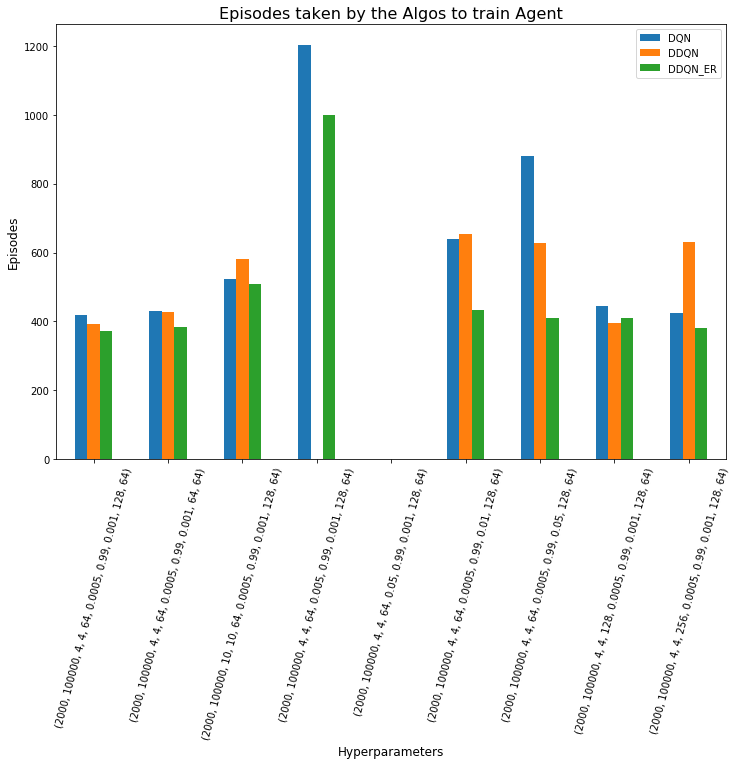

In [27]:
# Plot chart
df_plt.plot.bar(figsize=(12,8), rot=75)
plt.title('Episodes taken by the Algos to train Agent', fontsize = 16)
plt.xlabel('Hyperparameters', fontsize=12)
plt.ylabel('Episodes', fontsize=12)

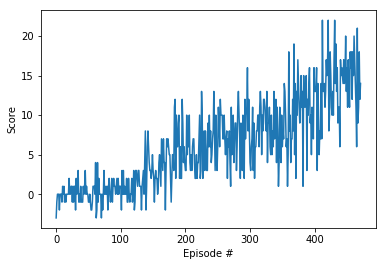

In [28]:
# plot the scores of the best result
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(results_best['score'].values[0])), results_best['score'].values[0])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Testing the model

Let us now test the model by loading the saved model, and see how the agent performs

In [29]:
# Retrieving the checkpoint filename by first retrieving the index value for the best result

er_df[er_df['episode'] == results_best['episode'].values[0]]


,E,N,k,C,M,lr,Y,t,fc1_units,fc2_units,a,b,p_err,episode,score
3,2000,100000,4,4,64,0.0005,0.99,0.001,128,64,0.7,0.7,0.001,372.0,"[-3.0, -1.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0...."


In [30]:
from dqn_agent import Agent

# index level of 3 means checkpoint file number 4
checkpoint_filename = 'checkpoint_ddqn_er_44.pth'

# Create the agent
hyperp_i = tuple(results_best[group_cols + ['a', 'b', 'p_err']].iloc[0,:])  # get hyperparameters from results_best as a tuple
use_ddqn = results_best['ddqn'].values[0]
exp_replay = results_best['er'].values[0]

agent = Agent(state_size=state_size, action_size=action_size, seed=0, hyperp = hyperp_i[1:10], ddqn=use_ddqn, 
                  hyperp_exp_replay = hyperp_i[10:13], exp_replay=exp_replay)

# Load the state dictionary from the checkpoint file.
agent.qnetwork_local.load_state_dict(torch.load(checkpoint_filename))

num_episodes = 100
scores_eval = []
for i_episode in range(1, num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    
    while True:
        action = agent.act(state, eps=0.)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]
        
        state = next_state
        score += reward
        if done:
            print('Episode {}: {}'. format(i_episode, score))
            scores_eval.append(score)
            break 




Episode 1: 10.0
Episode 2: 16.0
Episode 3: 14.0
Episode 4: 18.0
Episode 5: 14.0
Episode 6: 18.0
Episode 7: 13.0
Episode 8: 17.0
Episode 9: 15.0
Episode 10: 15.0
Episode 11: 13.0
Episode 12: 19.0
Episode 13: 7.0
Episode 14: 16.0
Episode 15: 18.0
Episode 16: 19.0
Episode 17: 11.0
Episode 18: 21.0
Episode 19: 8.0
Episode 20: 16.0
Episode 21: 18.0
Episode 22: 20.0
Episode 23: 23.0
Episode 24: 16.0
Episode 25: 17.0
Episode 26: 4.0
Episode 27: 8.0
Episode 28: 22.0
Episode 29: 8.0
Episode 30: 1.0
Episode 31: 3.0
Episode 32: 6.0
Episode 33: 9.0
Episode 34: 19.0
Episode 35: 18.0
Episode 36: 18.0
Episode 37: 12.0
Episode 38: 21.0
Episode 39: 16.0
Episode 40: 15.0
Episode 41: 8.0
Episode 42: 11.0
Episode 43: 18.0
Episode 44: 10.0
Episode 45: 9.0
Episode 46: 18.0
Episode 47: 2.0
Episode 48: 21.0
Episode 49: 0.0
Episode 50: 16.0
Episode 51: 9.0
Episode 52: 18.0
Episode 53: 15.0
Episode 54: 17.0
Episode 55: 19.0
Episode 56: 17.0
Episode 57: 14.0
Episode 58: 20.0
Episode 59: 3.0
Episode 60: 19.0
Epis

All the scores[10.0, 16.0, 14.0, 18.0, 14.0, 18.0, 13.0, 17.0, 15.0, 15.0, 13.0, 19.0, 7.0, 16.0, 18.0, 19.0, 11.0, 21.0, 8.0, 16.0, 18.0, 20.0, 23.0, 16.0, 17.0, 4.0, 8.0, 22.0, 8.0, 1.0, 3.0, 6.0, 9.0, 19.0, 18.0, 18.0, 12.0, 21.0, 16.0, 15.0, 8.0, 11.0, 18.0, 10.0, 9.0, 18.0, 2.0, 21.0, 0.0, 16.0, 9.0, 18.0, 15.0, 17.0, 19.0, 17.0, 14.0, 20.0, 3.0, 19.0, 23.0, 5.0, 15.0, 6.0, 7.0, 5.0, 20.0, 16.0, 2.0, 1.0, 15.0, 13.0, 14.0, 16.0, 13.0, 18.0, 4.0, 11.0, 6.0, 14.0, 16.0, 8.0, 8.0, 23.0, 4.0, 18.0, 22.0, 5.0, 19.0, 10.0, 16.0, 15.0, 19.0, 17.0, 20.0, 7.0, 17.0, 13.0, 18.0, 7.0]
Mean Score: 13.42


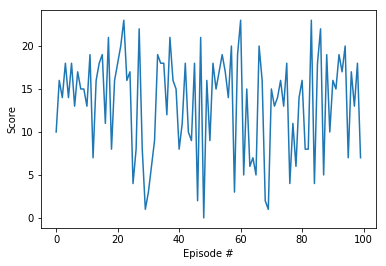

In [31]:
# Display the scores

print('All the scores{}'.format(scores_eval))
print("Mean Score: {}".format(np.mean(scores_eval)))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_eval)), scores_eval)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [32]:
# Closing the environment
env.close()